In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp

In [144]:
''# Define Hamiltonian Neural Network (HNN)
class NNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)


    def save_model(self, model_path="nnn_weights.pth"):
        """Save the model's state_dict to a file."""
        torch.save(self.state_dict(), model_path)
        print(f"Model weights saved to {model_path}")

    def load_model(self, model_path="nnn_weights.pth"):
        """Load the model's state_dict from a file."""
        self.load_state_dict(torch.load(model_path))
        self.eval()  # Set the model to evaluation mode
        print(f"Model weights loaded from {model_path}")


In [145]:
# Define Hamiltonian Neural Network (HNN)
class HNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

    def time_derivative(self, x):
        x = x.requires_grad_(True)
        H = self.forward(x)
        dH = torch.autograd.grad(H.sum(), x, create_graph=True)[0]
        dq_dt = dH[..., 1]  # ∂H/∂p
        dp_dt = -dH[..., 0]  # -∂H/∂q
        return torch.stack([dq_dt, dp_dt], dim=1)

    def save_model(self, model_path="hnn_weights.pth"):
        """Save the model's state_dict to a file."""
        torch.save(self.state_dict(), model_path)
        print(f"Model weights saved to {model_path}")

    def load_model(self, model_path="hnn_weights.pth"):
        """Load the model's state_dict from a file."""
        self.load_state_dict(torch.load(model_path))
        self.eval()  # Set the model to evaluation mode
        print(f"Model weights loaded from {model_path}")

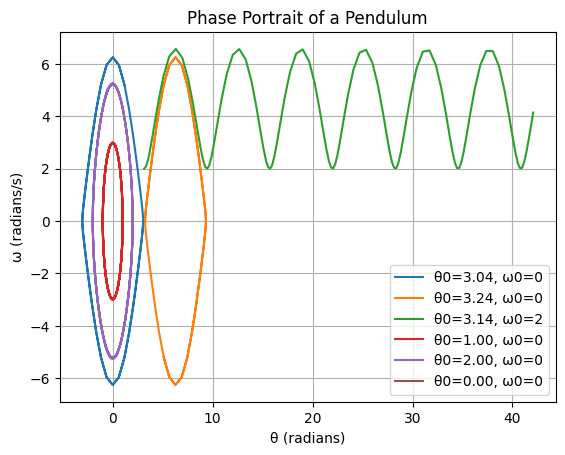

In [171]:
# Generate synthetic data from a simple pendulum
def pendulum_dynamics(t, y, g=9.81, l=1.0, m=1.0):
    theta, p = y
    dtheta_dt = p / (m*l**2)
    dp_dt = -m*g*l * np.sin(theta)
    return [dtheta_dt, dp_dt]

# Initial conditions near the separatrix and elsewhere
initial_conditions = [
    (np.pi - 0.1, 0),  # Just below the unstable equilibrium
    (np.pi + 0.1, 0),  # Just above the unstable equilibrium
    (np.pi, 2),        # On the unstable equilibrium
    (1, 0),            # Stable equilibrium
    (2, 0),            # Stable equilibrium
    (0,0)# (2, 8)             # High energy rotational motion

]
# Time span for the simulation
t_span = (0, 10)
t_eval = np.linspace(*t_span, 101)

def generate_data():
    data = []
    for theta0, omega0 in initial_conditions:
        sol = solve_ivp(pendulum_dynamics, t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
        data.append(sol.y.T)
    return np.vstack(data)

# Solving and plotting trajectories
for theta0, omega0 in initial_conditions:
    sol = solve_ivp(pendulum_dynamics, t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
    plt.plot(sol.y[0], sol.y[1], label=f'θ0={theta0:.2f}, ω0={omega0}')

# Plot enhancements
plt.title('Phase Portrait of a Pendulum')
plt.xlabel('θ (radians)')
plt.ylabel('ω (radians/s)')
plt.grid(True)
plt.legend()
plt.show()

Epoch 19000, Loss: 0.0002, LR: 0.002500: 100%|██████████| 20000/20000 [00:29<00:00, 689.20it/s]


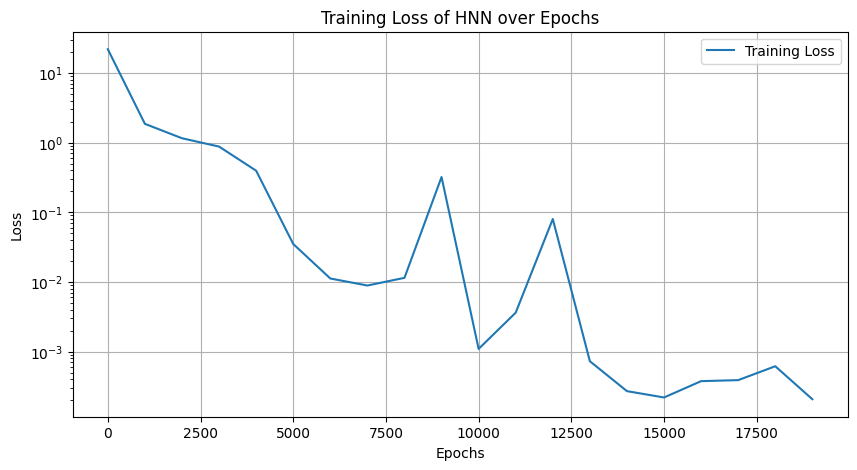

Model weights saved to hnn_weights.pth


In [147]:
data = generate_data()
np.random.shuffle(data)
data_tensor = torch.tensor(data, dtype=torch.float32)
nn_model = HNN()

optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1000, factor=0.5)
loss_fn = nn.MSELoss()
loss_history = []
number_of_epochs = 20000
increments_per_epoch = 1000

# Training loop with tqdm for progress and loss display
with tqdm(total=number_of_epochs) as pbar:
    for epoch in range(number_of_epochs):
        optimizer.zero_grad()
        pred_derivatives = nn_model.time_derivative(data_tensor)
        true_derivatives = torch.tensor([pendulum_dynamics(0, d) for d in data], dtype=torch.float32)
        loss = loss_fn(pred_derivatives, true_derivatives)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if epoch % increments_per_epoch == 0:
            loss_history.append(loss.item())
            # Update pbar description with current loss and the last learning rate
            pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        pbar.update()

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(0, number_of_epochs, increments_per_epoch), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of HNN over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Define a file path to save the model
model_path = "hnn_weights.pth"

# Save the model's state_dict
nn_model.save_model(model_path)


Model weights loaded from hnn_weights.pth


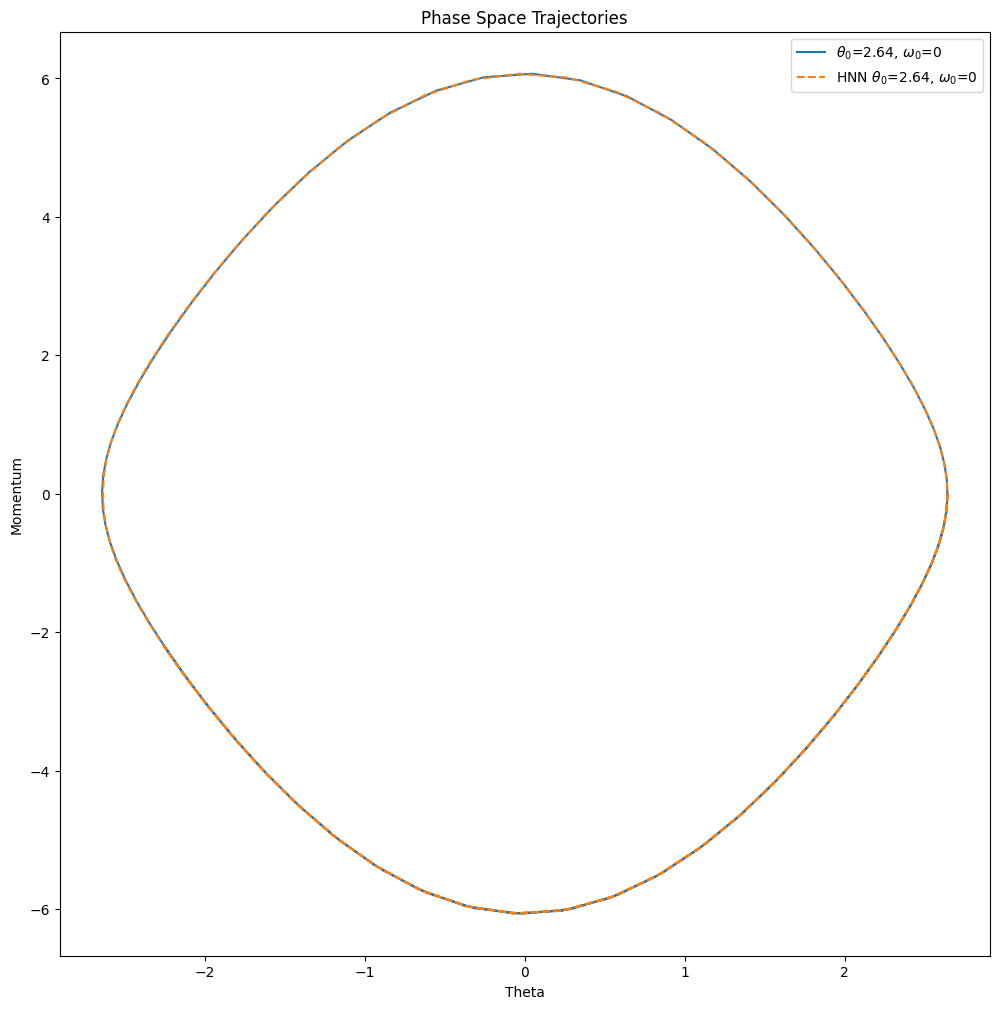

In [148]:
# Visualizing phase space trajectories

# Initial conditions near the separatrix and elsewhere
initial_conditions = [
    (np.pi - 0.5, 0),  # Just below the unstable equilibrium
    # (np.pi + 0.1, 0),  # Just above the unstable equilibrium
    # (np.pi, 2),        # On the unstable equilibrium
    # (0, 0),            # Stable equilibrium
    # (1, 0),            # Stable equilibrium
]
# Time span for the simulation
t_span = (0, 5)
t_eval = np.linspace(*t_span, 101)
def plot_trajectories():
    plt.figure(figsize=(12, 12))
    for theta0, omega0 in initial_conditions:
        sol = solve_ivp(pendulum_dynamics, t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
        plt.plot(sol.y[0], sol.y[1], label=rf'$\theta_0$={theta0:.2f}, $\omega_0$={omega0}')
        # Instantiate a new model
        nn_model = HNN()
        # Load the saved weights
        nn_model.load_model(model_path)
        # Set the model to evaluation mode (important if using BatchNorm or Dropout)
        nn_model.eval()
        # Solve using HNN
        sol_hnn = solve_ivp(lambda t, y: nn_model.time_derivative(torch.tensor(y[None, :], dtype=torch.float32)).squeeze().detach().numpy(),
                            t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
        plt.plot(sol_hnn.y[0], sol_hnn.y[1], '--', label=rf'HNN $\theta_0$={theta0:.2f}, $\omega_0$={omega0}')
        # y_pred = np.array([theta0, omega0])
        # traj = [y_pred]
        # for _ in t_eval:
        #     y_pred_tensor = torch.tensor(y_pred[None, :], dtype=torch.float32)  # Add batch dimension
        #     y_pred = y_pred + nn_model.time_derivative(y_pred_tensor).squeeze().detach().numpy() * (t_eval[1] - t_eval[0])
        #     traj.append(y_pred)
        # traj = np.array(traj)
        # plt.plot(traj[:, 0], traj[:, 1], '-', label=rf'HNN $\theta_0$={theta0:.2f}, $\omega_0$={omega0}')

    plt.xlabel("Theta")
    plt.ylabel("Momentum")
    plt.legend()
    plt.title("Phase Space Trajectories")
    plt.show()

plot_trajectories()


Epoch 19000, Loss: 0.0085, LR: 0.005000: 100%|██████████| 20000/20000 [00:22<00:00, 896.73it/s]


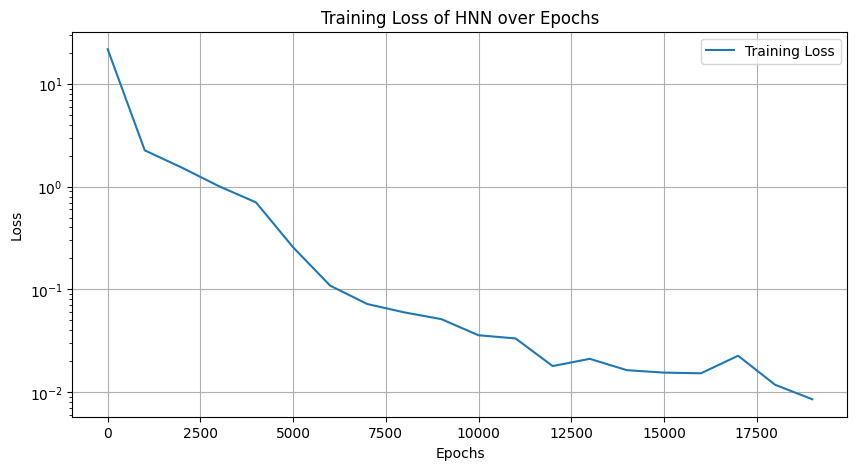

Model weights saved to nnn_weights.pth


In [149]:
# data = generate_data()
# data_tensor = torch.tensor(data, dtype=torch.float32)
nn_model = NNN()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5)
# loss_fn = nn.MSELoss()
loss_history = []
# number_of_epochs = 50000
# increments_per_epoch = 1000

# Training loop with tqdm for progress and loss display
with tqdm(total=number_of_epochs) as pbar:
    for epoch in range(number_of_epochs):
        optimizer.zero_grad()
        pred_derivatives = nn_model(data_tensor)
        true_derivatives = torch.tensor([pendulum_dynamics(0, d) for d in data], dtype=torch.float32)
        loss = loss_fn(pred_derivatives, true_derivatives)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if epoch % increments_per_epoch == 0:
            loss_history.append(loss.item())
            # Update pbar description with current loss and the last learning rate
            pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        pbar.update()

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(0, number_of_epochs, increments_per_epoch), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of HNN over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Define a file path to save the model
model_path = "nnn_weights.pth"

# Save the model's state_dict
nn_model.save_model(model_path)

Model weights loaded from hnn_weights.pth
Model weights loaded from nnn_weights.pth
Model weights loaded from hnn_weights.pth
Model weights loaded from nnn_weights.pth
Model weights loaded from hnn_weights.pth
Model weights loaded from nnn_weights.pth
Model weights loaded from hnn_weights.pth
Model weights loaded from nnn_weights.pth
Model weights loaded from hnn_weights.pth
Model weights loaded from nnn_weights.pth


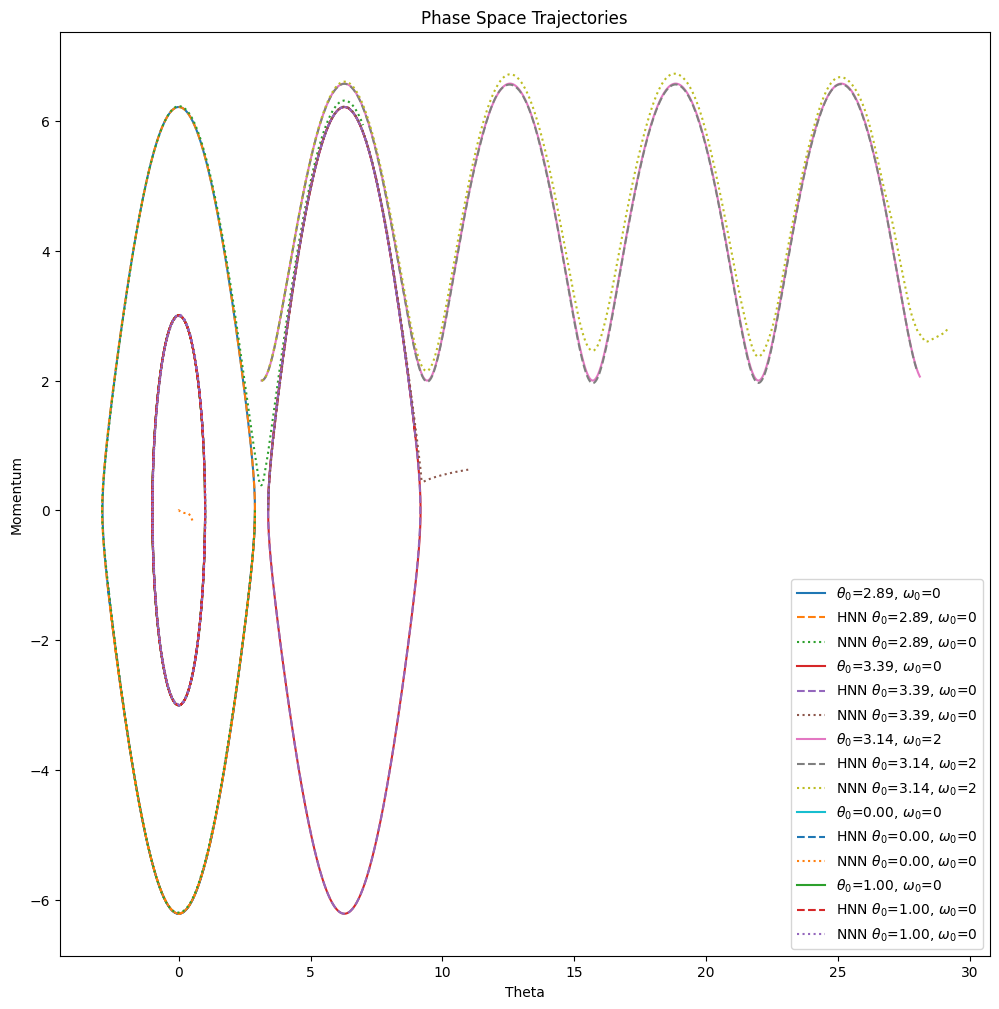

In [150]:
# Visualizing phase space trajectories

# Initial conditions near the separatrix and elsewhere
initial_conditions = [
    (np.pi - 0.25, 0),  # Just below the unstable equilibrium
    (np.pi + 0.25, 0),  # Just above the unstable equilibrium
    (np.pi, 2),        # On the unstable equilibrium
    (0, 0),            # Stable equilibrium
    (1, 0),            # Stable equilibrium
]
# Time span for the simulation
t_span = (0, 2*np.pi)
t_eval = np.linspace(*t_span, 1001)
def plot_trajectories():
    plt.figure(figsize=(12, 12))
    for theta0, omega0 in initial_conditions:
        sol = solve_ivp(pendulum_dynamics, t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
        plt.plot(sol.y[0], sol.y[1], label=rf'$\theta_0$={theta0:.2f}, $\omega_0$={omega0}')
        # Instantiate a new model
        nn_model = HNN()
        # Load the saved weights
        nn_model.load_model(model_path = "hnn_weights.pth")
        sol_hnn = solve_ivp(lambda t, y: nn_model.time_derivative(torch.tensor(y[None, :], dtype=torch.float32)).squeeze().detach().numpy(),
                            t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
        plt.plot(sol_hnn.y[0], sol_hnn.y[1], '--', label=rf'HNN $\theta_0$={theta0:.2f}, $\omega_0$={omega0}')
        # Instantiate a new model
        nn_model = NNN()
        # Load the saved weights
        nn_model.load_model(model_path = "nnn_weights.pth")
        sol_hnn = solve_ivp(lambda t, y: nn_model(torch.tensor(y[None, :], dtype=torch.float32)).squeeze().detach().numpy(),
                            t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
        plt.plot(sol_hnn.y[0], sol_hnn.y[1], ':', label=rf'NNN $\theta_0$={theta0:.2f}, $\omega_0$={omega0}')

    plt.xlabel("Theta")
    plt.ylabel("Momentum")
    plt.legend()
    plt.title("Phase Space Trajectories")
    plt.show()

plot_trajectories()


In [176]:
# Define Lagrangian Neural Network (LNN)
class LNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)  # Output is the Lagrangian L(q, dq)
        )

    def forward(self, x):
        return self.net(x)

    def time_derivative(self, x, m=1.0, l=1.0, g=9.81):
        x = x.requires_grad_(True)
        L = self.forward(x)
        dL = torch.autograd.grad(L.sum(), x, create_graph=True)[0]
        dL_dq = dL[:, 0]  # ∂L/∂q
        dL_ddq = dL[:, 1]  # ∂L/∂dq

        # Compute time derivative of dL_ddq
        ddL_ddq_dt = torch.autograd.grad(dL_ddq.sum(), x, create_graph=True)[0][:, 1]
        return torch.stack([x[:, 1], ddL_ddq_dt - dL_dq], dim=1)

    def save_model(self, model_path="lnn_weights.pth"):
        """Save the model's state_dict to a file."""
        torch.save(self.state_dict(), model_path)
        print(f"Model weights saved to {model_path}")

    def load_model(self, model_path="lnn_weights.pth"):
        """Load the model's state_dict from a file."""
        self.load_state_dict(torch.load(model_path))
        self.eval()  # Set the model to evaluation mode
        print(f"Model weights loaded from {model_path}")

Epoch 49000, Loss: 0.0002, LR: 0.000625: 100%|██████████| 50000/50000 [01:33<00:00, 535.61it/s]


Model weights saved to lnn_weights.pth


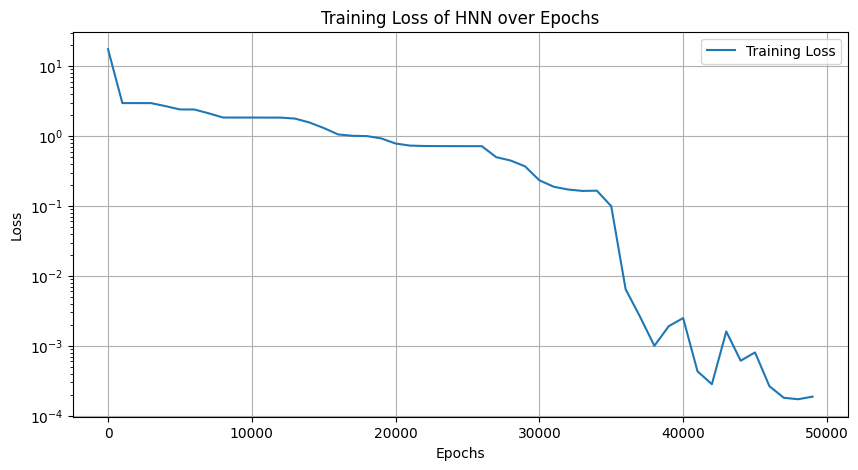

In [180]:
nn_model = LNN()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5)
number_of_epochs = 50000
loss_history = []


# Training loop with tqdm for progress and loss display
with tqdm(total=number_of_epochs) as pbar:
    for epoch in range(number_of_epochs):
        optimizer.zero_grad()
        pred_derivatives = nn_model.time_derivative(data_tensor)
        true_derivatives = torch.tensor([pendulum_dynamics(0, d) for d in data], dtype=torch.float32)
        loss = loss_fn(pred_derivatives, true_derivatives)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if epoch % increments_per_epoch == 0:
            loss_history.append(loss.item())
            # Update pbar description with current loss and the last learning rate
            pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        pbar.update()

nn_model.save_model(model_path = "lnn_weights.pth")
# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(0, number_of_epochs, increments_per_epoch), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of HNN over Epochs')
plt.legend()
plt.grid(True)
plt.show()






Model weights loaded from lnn_weights.pth
Model weights loaded from lnn_weights.pth
Model weights loaded from lnn_weights.pth


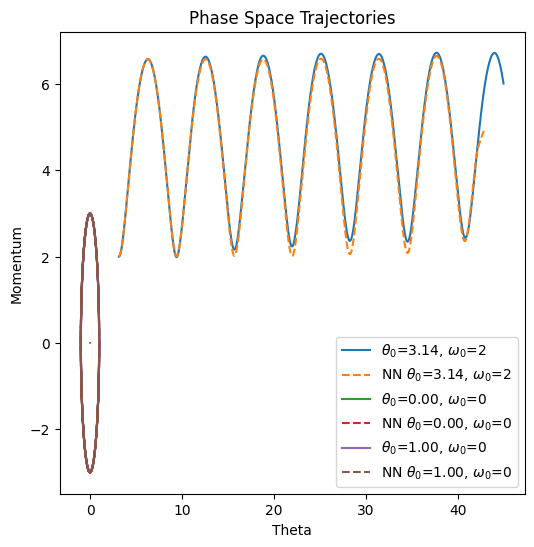

In [181]:
# Visualizing phase space trajectories

# Initial conditions near the separatrix and elsewhere
initial_conditions = [
    # (np.pi - 0.5, 0),  # Just below the unstable equilibrium
    # (np.pi + 0.1, 0),  # Just above the unstable equilibrium
    (np.pi, 2),        # On the unstable equilibrium
    (0, 0),            # Stable equilibrium
    (1, 0),            # Stable equilibrium
]
# Time span for the simulation
t_span = (0, 10)
t_eval = np.linspace(*t_span, 10000)

def plot_trajectories(nn_model):
    plt.figure(figsize=(6, 6))
    for theta0, omega0 in initial_conditions:
        sol = solve_ivp(pendulum_dynamics, t_span, [theta0, omega0], t_eval=t_eval, method='RK45')
        plt.plot(sol.y[0], sol.y[1], label=rf'$\theta_0$={theta0:.2f}, $\omega_0$={omega0}')
    # for y0 in initial_conditions:
        nn_model = LNN()
        # Load the saved weights
        nn_model.load_model(model_path = "lnn_weights.pth")
        sol_hnn = solve_ivp(lambda t, y: nn_model.time_derivative(torch.tensor(y[None, :], dtype=torch.float32)).squeeze().detach().numpy(),
                            t_span, [theta0, omega0], t_eval=t_eval, method='RK45', rtol=1e-10)
        plt.plot(sol_hnn.y[0], sol_hnn.y[1], '--', label=rf'NN $\theta_0$={theta0:.2f}, $\omega_0$={omega0}')

    plt.xlabel("Theta")
    plt.ylabel("Momentum")
    plt.legend()
    plt.title("Phase Space Trajectories")
    plt.show()

plot_trajectories(nn_model)
